In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cp
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (15, 3)
sns.set_style('whitegrid')

In [3]:
def create_df(house):
    
    df = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/complete_dataset.csv")
    ef = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/Elspotprices.csv",sep=';',decimal=',')
    cf = pd.read_csv("carbon_emissions_data.csv",decimal=',')
    
    df['Time'] = pd.to_datetime(df['Time'])
    ef['HourDK'] = pd.to_datetime(ef['HourDK'])
    cf['Minutes5DK'] = pd.to_datetime(cf['Minutes5DK'])
    
    mf = ef[ef['PriceArea']=='DK1'].merge(df,left_on='HourDK', right_on='Time')
    mf = mf.merge(cf, left_on = 'HourDK', right_on = 'Minutes5DK')
    
    data = pd.DataFrame()
    data['prod'] = mf[f'prod_{str(house)}'].to_numpy()
    data['cons'] = mf[f'cons_{str(house)}'].to_numpy()
    data['price'] = mf['SpotPriceDKK'].to_numpy()/1000
    data['carbon'] = mf['CO2Emission'].to_numpy()
    
    return data

In [4]:
def acc_cost(prod, cons, price, charge,sbr):
    surplus = prod-cons
    cost = []
    for i in range(len(surplus)):
        val = surplus[i] - charge[i]
        
        if (surplus[i]>=0) and (val>=0): # battery charged and excess sold
            cost.append(val*price[i]*sbr)
            
        elif (surplus[i]>=0) and (val<0): # battery charged and more bought
            cost.append(abs(val)*price[i])
            
        elif (surplus[i]<0) and (val>=0): # battery discharged and excess sold
            cost.append(val*price[i]*sbr)
        
        else: # battery discharged and more bought
            cost.append(abs(val)*price[i])
    
    cost = [np.sum(cost[:i]) for i in range(1,len(cost)+1)]
    
    return cost

In [5]:
def ccost_cvxpy(surplus, charge, price, sbr):
    cost = 0
    for i in range(len(surplus)):
        val = surplus[i] - charge[i] #  +ve charge = battery is being discharged, -ve charge = battery is being charged
        cost += cp.maximum(val, 0) * price[i] * sbr
        cost += cp.minimum(val, 0) * price[i] * -1.0
    return cost

In [6]:
def optimizer(num_steps = 24, start_ind=2524, house='h16', sbr_val = 0.5, deg_rate=0.05):
    
    df = create_df(house)
    
    num_steps = num_steps
    start = start_ind

    consumption = df['cons'][start:start+num_steps].to_numpy()
    production = df['prod'][start:start+num_steps].to_numpy()
    surplus = production - consumption
    price = df['price'][start:start+num_steps].to_numpy()
    carbon = df['carbon'][start:start+num_steps].to_numpy()
    
    sbr = sbr_val
    deg_rate = deg_rate
    
    battery_capacity = 13
    max_charge = 7

    # Define variables
    battery_state = cp.Variable(num_steps + 1, nonneg=True)  # battery state of charge
    charge = cp.Variable(num_steps, nonneg=False)  # battery charging/discharging rate

    # Define objective function
    objective = ccost_cvxpy(surplus, charge, price, sbr)

    # Define constraints
    constraints = [
        battery_state[0] == 0,
        battery_state <= battery_capacity,
        battery_state[1:] == battery_state[:-1]*(1-deg_rate) + charge,
        #-charge <= battery_state[:-1],  # discharging rate constraint
        charge <= max_charge,  # charging rate constraint
        -charge >= -max_charge,
    ]


    # Define optimization problem
    problem = cp.Problem(cp.Minimize(objective), constraints)

    # Solve optimization problem
    scipy_opts = {"solver": cp.OSQP}
    
    try:
        problem.solve(verbose=False, **scipy_opts)
    except:
        optimizer(start_ind=start+10)

    costs = [ccost_cvxpy(surplus[:i], charge[:i], price[:i],sbr).value for i in range(1,len(surplus)+1)]

    print(f'Problem Status: {problem.status}')
    print(f'Total Cost: {problem.value}')
    
    l = acc_cost(production, consumption, price, charge.value,sbr)
    no_grid = [consumption[i]*price[i] for i in range(len(price))]
    no_grid_cumm = [np.sum(no_grid[:i]) for i in range(1,len(price)+1)]
    
    df = pd.DataFrame()
    df['Charge'] = charge.value
    df['Bat. State'] = battery_state[:len(charge.value)].value
    df['Surplus'] = production-consumption
    df['Price'] = price
    df['Costs'] = costs
    df['Act. Costs'] = l
    df['No grid'] = no_grid_cumm
    df = df.round(3)
    
    return df

In [7]:
class MCP:
    def __init__(self, house,num_steps=24, sbr=0.5, start_ind=2600,deg_rate=0.05):
        self.house = house
        self.num_steps = num_steps
        self.sbr = sbr
        self.start_ind = start_ind
        self.deg_rate = deg_rate
    
        self.data = create_df(self.house)
        self.opt = optimizer(self.num_steps, self.start_ind, self.house, self.sbr, self.deg_rate)
    
    def return_data(self):
        return self.data
    
    def return_opt(self):
        return self.opt
    
    def full_plot(self, drop=[]):
        temp = self.opt.copy()
        temp = temp.drop(drop, axis=1)
        temp.plot()
        plt.title(f'MCP for house {self.house} at index {self.start_ind}')
        plt.xlabel('Timestep')
        plt.ylabel('')
        plt.show()
    
    def mag_plot(self,drop=[], start=0,end=5):
        temp = self.opt.copy()
        temp = temp.drop(drop, axis=1)
        temp[start:end].plot()
        plt.title(f'MCP for house {self.house}, index {self.start_ind}, magnified: {start}:{end}')
        plt.xlabel('Timestep')
        plt.ylabel('')
        plt.show()
    

In [8]:
h16 = MCP('h16', num_steps=24*3)

Problem Status: optimal
Total Cost: 115.40782466141907


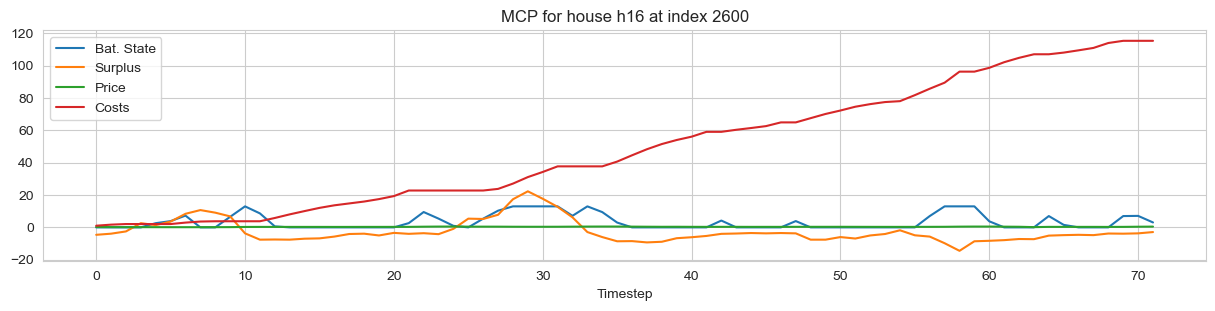

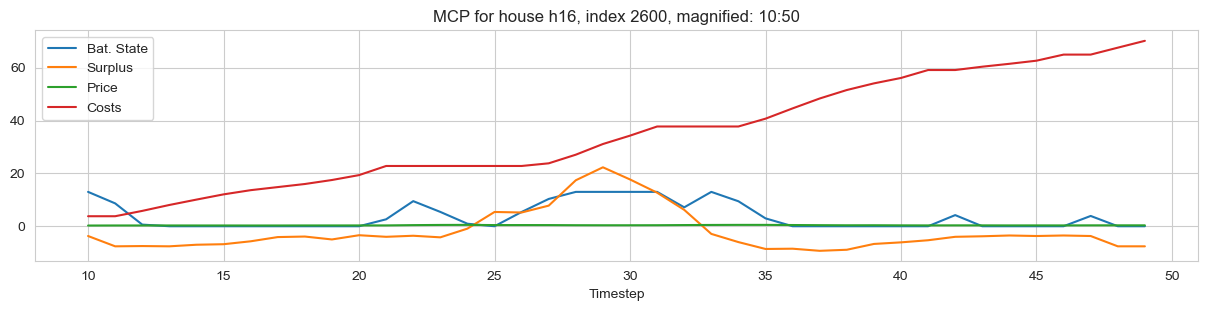

In [9]:
h16.full_plot(drop=['Act. Costs', 'No grid', 'Charge'])
h16.mag_plot(drop=['Act. Costs', 'No grid', 'Charge'], start=10, end=50)